In [1]:
# Import required libraries
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import matplotlib.patches as patches


In [2]:
# Load the input image
def load_image(path):
    img = cv.imread(path)
    if img is None:
        print("Error: Could not load image")
        return None
    return img

In [3]:
# Convert to grayscale
def convert_to_gray(img):
    if len(img.shape) == 3:
        return cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return img


In [4]:
 #Create Low Pass Filter (Butterworth)
def create_lowpass_filter(shape, cutoff, order=2):
    rows, cols = shape
    crow, ccol = rows//2, cols//2

    # Create coordinate matrices
    u = np.arange(rows).reshape(-1, 1) - crow
    v = np.arange(cols) - ccol
    D = np.sqrt(u**2 + v**2)

    # Butterworth Low Pass Filter
    H = 1 / (1 + (D / cutoff)**(2*order))
    return H


In [5]:
# Create High Pass Filter (Butterworth)
def create_highpass_filter(shape, cutoff, order=2):
    return 1 - create_lowpass_filter(shape, cutoff, order)

In [6]:
# Create Band Pass Filter
def create_bandpass_filter(shape, low_cutoff, high_cutoff, order=2):
    rows, cols = shape
    crow, ccol = rows//2, cols//2

    u = np.arange(rows).reshape(-1, 1) - crow
    v = np.arange(cols) - ccol
    D = np.sqrt(u**2 + v**2)

    # Band Pass Filter
    H = 1 / (1 + (D * (high_cutoff - low_cutoff) /
              (D**2 - high_cutoff * low_cutoff))**(2*order))
    return H


In [7]:
# Frequency domain filtering function
def frequency_domain_filter(img, filter_type='lowpass', cutoff=30, order=2):
    # Convert to float
    f = img.astype(np.float32)

    # Apply 2D FFT
    F = np.fft.fft2(f)
    F_shifted = np.fft.fftshift(F)

    # Create filter based on type
    if filter_type == 'lowpass':
        H = create_lowpass_filter(f.shape, cutoff, order)
    elif filter_type == 'highpass':
        H = create_highpass_filter(f.shape, cutoff, order)
    elif filter_type == 'bandpass':
        H = create_bandpass_filter(f.shape, cutoff, cutoff*2, order)

    # Apply filter
    G_shifted = F_shifted * H

    # Inverse FFT
    G = np.fft.ifftshift(G_shifted)
    filtered_img = np.fft.ifft2(G)
    filtered_img = np.real(filtered_img)

    # Normalize to 0-255 range
    filtered_img = np.clip(filtered_img, 0, 255).astype(np.uint8)

    return filtered_img, H, F_shifted

In [8]:
# Main processing function
def process_image(image_path):
    # Load and process image
    img = load_image(image_path)
    if img is None:
        return

    gray_img = convert_to_gray(img)

    # Apply different filters
    low_filtered, lpf_mask, fft_img = frequency_domain_filter(
        gray_img, 'lowpass', cutoff=50)
    high_filtered, hpf_mask, _ = frequency_domain_filter(
        gray_img, 'highpass', cutoff=30)
    band_filtered, bpf_mask, _ = frequency_domain_filter(
        gray_img, 'bandpass', cutoff=20)

    # Display results
    plt.figure(figsize=(15, 12))

    # Original image
    plt.subplot(3, 3, 1)
    plt.imshow(gray_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # FFT magnitude spectrum
    plt.subplot(3, 3, 2)
    magnitude_spectrum = np.log(np.abs(fft_img) + 1)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('FFT Magnitude Spectrum')
    plt.axis('off')

    # Low Pass Filter mask
    plt.subplot(3, 3, 3)
    plt.imshow(lpf_mask, cmap='gray')
    plt.title('Low Pass Filter Mask')
    plt.axis('off')

    # Low Pass Filtered result
    plt.subplot(3, 3, 4)
    plt.imshow(low_filtered, cmap='gray')
    plt.title('Low Pass Filtered')
    plt.axis('off')

    # High Pass Filter mask
    plt.subplot(3, 3, 5)
    plt.imshow(hpf_mask, cmap='gray')
    plt.title('High Pass Filter Mask')
    plt.axis('off')

    # High Pass Filtered result
    plt.subplot(3, 3, 6)
    plt.imshow(high_filtered, cmap='gray')
    plt.title('High Pass Filtered')
    plt.axis('off')

    # Band Pass Filter mask
    plt.subplot(3, 3, 7)
    plt.imshow(bpf_mask, cmap='gray')
    plt.title('Band Pass Filter Mask')
    plt.axis('off')

    # Band Pass Filtered result
    plt.subplot(3, 3, 8)
    plt.imshow(band_filtered, cmap='gray')
    plt.title('Band Pass Filtered')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return gray_img, low_filtered, high_filtered, band_filtered


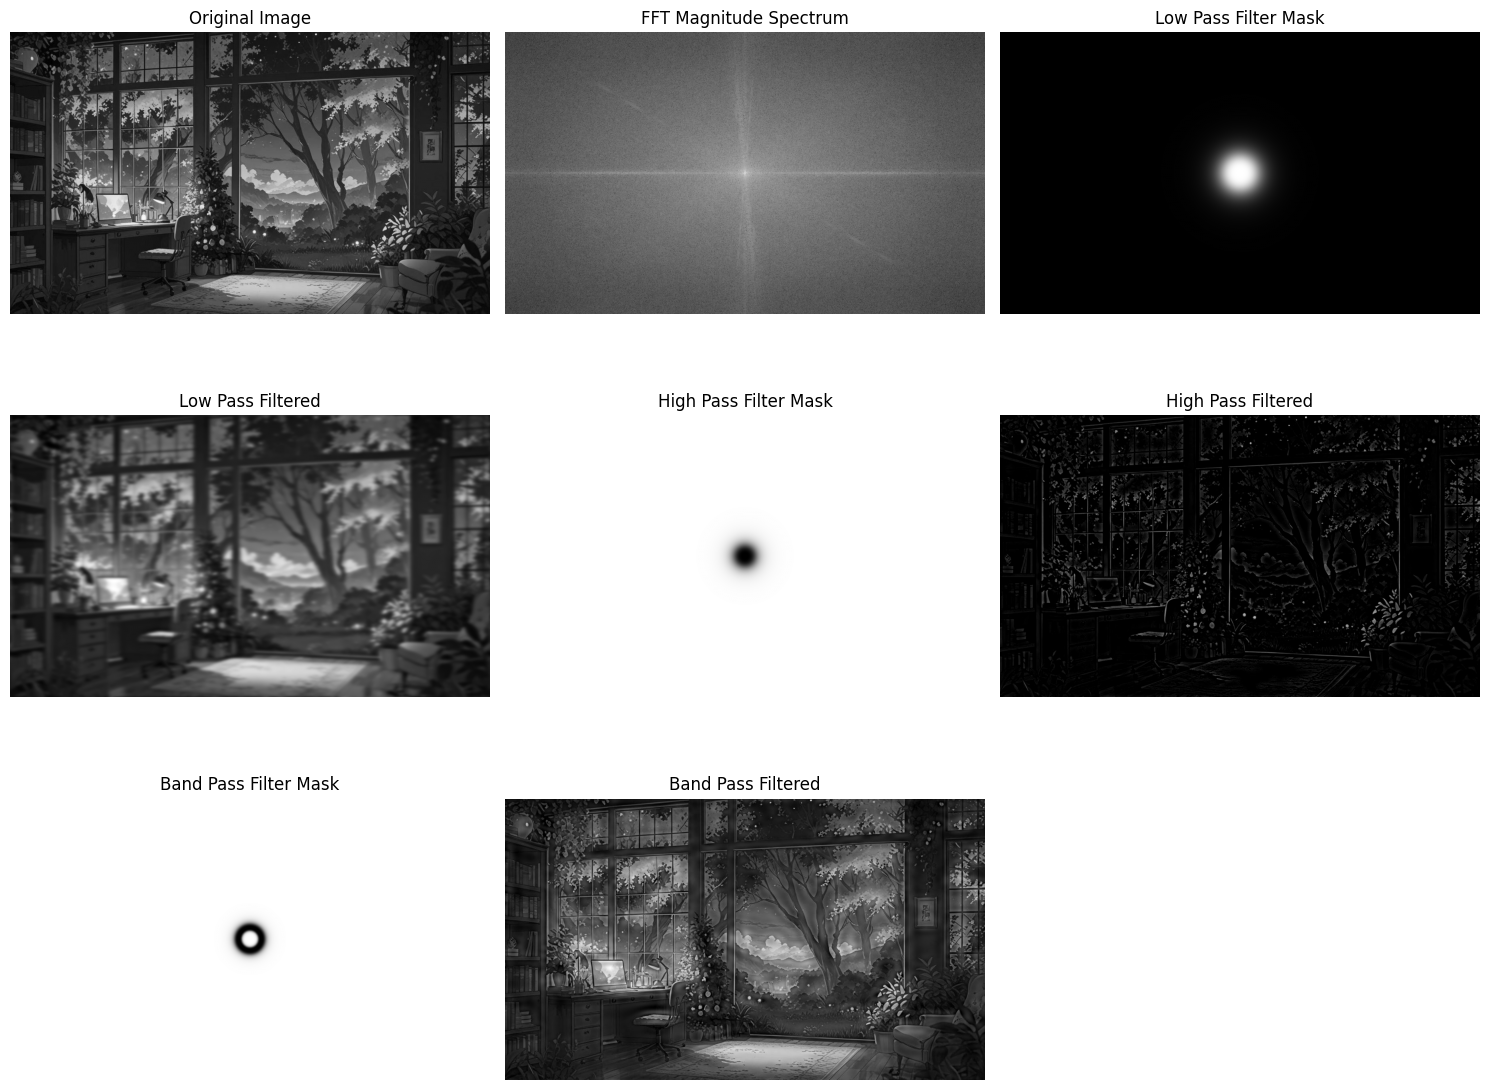

In [9]:
# Example usage
image_path = "exampleimage.jpg"
original, lpf_result, hpf_result, bpf_result = process_image(image_path)